In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [122]:
class BaseOptimizer:
  def __init__(self, lr, k_reg):
    self.lr = lr
    self.k_reg = k_reg

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    return weights - gradient * self.lr + self.k_reg * weights



class BatchGD:
    def __init__(self, dim, epochs, loss, loss_grad,lamb=0.4, optimizer = BaseOptimizer(1e-2, 1e-4)):
        self.dim = dim
        self.epochs = epochs
        self.weights = np.random.rand(dim)
        self.loss = loss
        self.loss_grad = loss_grad
        self.lamb = lamb
        self.optimizer = optimizer


    def train(self, xs, ys, bs, q_precision=1e-5, weights_precision=1e-4):
        q = self.loss(self.weights, xs, ys).mean()
        losses = []
        for i in range(self.epochs):
            batch_idxs = np.random.choice(np.arange(len(xs)), size=bs, replace=False)
            batch_xs = xs[batch_idxs, :]
            batch_ys = ys[batch_idxs]

            eps = self.loss(self.weights, batch_xs, batch_ys).mean()
            losses.append(q)
            prev_weights = self.weights

            self.weights = self.optimizer.optimize(self.weights, self.loss_grad, batch_xs, batch_ys)

            prev_q = q
            q = self.lamb * eps + (1 - self.lamb) * prev_q

            print(f'Epoch: {i + 1}. Loss: {q}')

            if np.abs(q - prev_q) < q_precision and np.abs(self.weights - prev_weights).mean() < weights_precision:
                return losses
        return losses

    def predict(self, xs):
        return xs @ self.weights

In [123]:
f = lambda x: -5 * x[:, 0] + 3 * x[:, 1]
loss = lambda weights, xs, ys: (xs @ weights - ys) ** 2
loss_grad = lambda weights, xs, ys: np.array([2 * (xs @ weights - ys) * (xs[:, i]) for i in range(len(weights))])

In [124]:
a, b = -10, 10
xs = (b - a) * np.random.random_sample((100, 1)) + a
xs =  np.append(xs, np.ones((100, 1)), axis=1)
ys = f(xs).flatten()

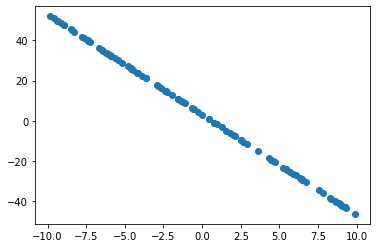

In [125]:
plt.scatter(xs[:, 0], ys)

### SGD

In [88]:
sgd_algo = BatchGD(2, 1000, loss, loss_grad)

In [89]:
sgd_losses = sgd_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1109.2761528472129
Epoch: 2. Loss: 672.1471270667001
Epoch: 3. Loss: 432.87283838340943
Epoch: 4. Loss: 263.3555894408489
Epoch: 5. Loss: 158.75563291113488
Epoch: 6. Loss: 98.03325665529884
Epoch: 7. Loss: 59.28938235869622
Epoch: 8. Loss: 36.00275087082732
Epoch: 9. Loss: 22.118292370283047
Epoch: 10. Loss: 13.586204039462503
Epoch: 11. Loss: 8.496086026583642
Epoch: 12. Loss: 5.1127309399192455
Epoch: 13. Loss: 3.5096885035377103
Epoch: 14. Loss: 2.3986872643727746
Epoch: 15. Loss: 1.6817438323652567
Epoch: 16. Loss: 1.050074558004884
Epoch: 17. Loss: 0.6302929596640567
Epoch: 18. Loss: 1.2725163813786897
Epoch: 19. Loss: 1.0890385094291837
Epoch: 20. Loss: 1.3143931569607952
Epoch: 21. Loss: 1.5192887842346106
Epoch: 22. Loss: 1.9366525703810136
Epoch: 23. Loss: 1.4297020810785468
Epoch: 24. Loss: 1.3166806994393982
Epoch: 25. Loss: 0.9067782455419329
Epoch: 26. Loss: 1.948631429859586
Epoch: 27. Loss: 1.4698587122504183
Epoch: 28. Loss: 0.9154595735568752
Epoch: 29

Text(0.5, 1.0, 'SGD Loss (Q)')

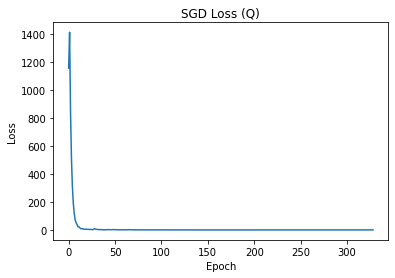

In [19]:
plt.plot(sgd_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Q)')

In [20]:
preds = sgd_algo.predict(xs)

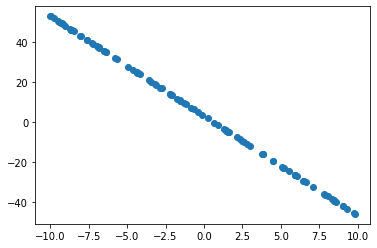

In [21]:
plt.scatter(xs[:, 0], preds)

### Minibatch (20)

In [24]:
minibatch_algo = BatchGD(2, 1000, loss, loss_grad)

In [ ]:
minibatch_losses = minibatch_algo.train(xs, ys, bs=40)

Text(0.5, 1.0, 'Minibatch Loss (Q)')

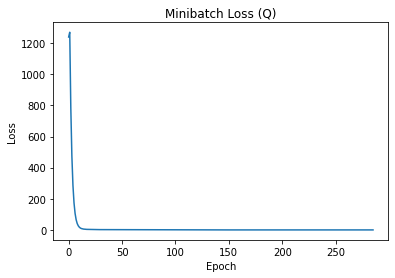

In [26]:
plt.plot(minibatch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Minibatch Loss (Q)')

In [27]:
preds = minibatch_algo.predict(xs)

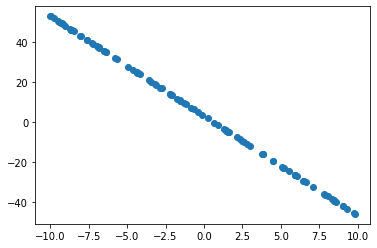

In [28]:
plt.scatter(xs[:, 0], preds)

### Batch (full dataset)

In [32]:
batch_algo = BatchGD(2, 1000, loss, loss_grad, 1.0)

In [ ]:
batch_losses = batch_algo.train(xs, ys, bs=100)

Text(0.5, 1.0, 'GD Loss (Q)')

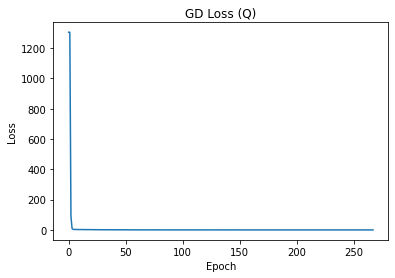

In [34]:
plt.plot(batch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GD Loss (Q)')

In [35]:
preds = batch_algo.predict(xs)

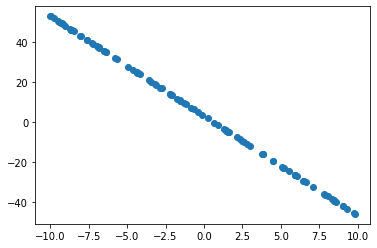

In [36]:
plt.scatter(xs[:, 0], preds)

In [53]:
scaled = xs.copy()
scaled[:, 0] = (scaled[:, 0] - scaled[:, 0].mean(axis=0)) / scaled[:, 0].std(axis=0)
ys_scaled = f(scaled).flatten()

In [ ]:
sgd_algo_scaled = BatchGD(2, 1000, loss, loss_grad)
sgd_losses_scaled = sgd_algo_scaled.train(scaled, ys_scaled, 1)

Text(0.5, 1.0, 'SGD Loss (Scaled) (Q)')

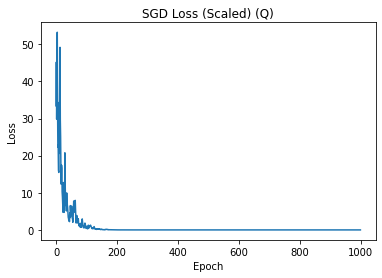

In [55]:
plt.plot(sgd_losses_scaled)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Loss (Scaled) (Q)')

## Nesterov 

In [116]:
class NesterovOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights - self.gamma * self.v, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v

optimizer = NesterovOptimizer()
sgd_nesterov_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_nesterov_losses = sgd_nesterov_algo.train(xs, ys, 1)

Epoch: 1. Loss: 795.692743223957
Epoch: 2. Loss: 1318.835579505002
Epoch: 3. Loss: 1544.1785771750438
Epoch: 4. Loss: 1066.3870806873344
Epoch: 5. Loss: 639.9498298818852
Epoch: 6. Loss: 388.0468354304852
Epoch: 7. Loss: 265.74957753077786
Epoch: 8. Loss: 161.58889900191076
Epoch: 9. Loss: 98.2054799288559
Epoch: 10. Loss: 194.04232774977285
Epoch: 11. Loss: 711.0254466667262
Epoch: 12. Loss: 665.347880754885
Epoch: 13. Loss: 417.00363419328335
Epoch: 14. Loss: 321.404318414267
Epoch: 15. Loss: 194.77970092479651
Epoch: 16. Loss: 123.73097913887716
Epoch: 17. Loss: 75.67860051646973
Epoch: 18. Loss: 49.22189293344368
Epoch: 19. Loss: 30.49492509667538
Epoch: 20. Loss: 21.57746361165702
Epoch: 21. Loss: 14.529776359218431
Epoch: 22. Loss: 30.039963900964793
Epoch: 23. Loss: 18.84534149798984
Epoch: 24. Loss: 41.17439169327632
Epoch: 25. Loss: 59.38030945454151
Epoch: 26. Loss: 35.77078819064754
Epoch: 27. Loss: 43.986315080989534
Epoch: 28. Loss: 36.21346549549811
Epoch: 29. Loss: 23.38

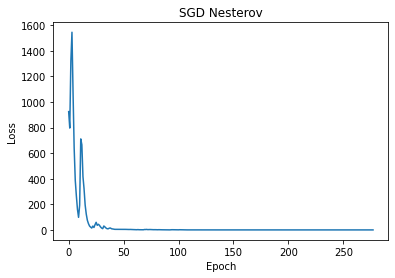

In [117]:
plt.plot(sgd_nesterov_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Nesterov')
plt.show()

## Momentum

In [114]:
class MomentumOptimizer:
  def __init__(self,lr=1e-3, gamma=0.9):
    self.v = 0
    self.lr = lr
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.v = self.gamma * self.v + gradient * self.lr
    return weights - self.v

optimizer = MomentumOptimizer()
sgd_momentum_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_monentum_losses = sgd_momentum_algo.train(xs, ys, 1)

Epoch: 1. Loss: 644.4738225241834
Epoch: 2. Loss: 484.9815533581939
Epoch: 3. Loss: 385.71598377115646
Epoch: 4. Loss: 481.45790460956084
Epoch: 5. Loss: 902.2927601317367
Epoch: 6. Loss: 653.3377254444297
Epoch: 7. Loss: 425.62808028968107
Epoch: 8. Loss: 279.71249418529294
Epoch: 9. Loss: 195.63877638897088
Epoch: 10. Loss: 117.57994391059869
Epoch: 11. Loss: 78.97665666301123
Epoch: 12. Loss: 67.45913337940934
Epoch: 13. Loss: 40.691804567484205
Epoch: 14. Loss: 147.01229486587417
Epoch: 15. Loss: 88.44020122508503
Epoch: 16. Loss: 218.3836365027576
Epoch: 17. Loss: 222.5345943149213
Epoch: 18. Loss: 320.4693054700708
Epoch: 19. Loss: 224.2286231698711
Epoch: 20. Loss: 135.35987018417651
Epoch: 21. Loss: 81.86884161064411
Epoch: 22. Loss: 49.221733353413136
Epoch: 23. Loss: 29.62314810133432
Epoch: 24. Loss: 20.07210299174407
Epoch: 25. Loss: 31.495525339155655
Epoch: 26. Loss: 24.94985390748377
Epoch: 27. Loss: 86.73969174593799
Epoch: 28. Loss: 54.547102439482906
Epoch: 29. Loss: 

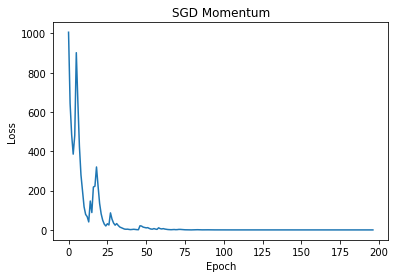

In [115]:
plt.plot(sgd_monentum_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD Momentum')
plt.show()

## AdaGrad

In [134]:
class AdaGradOptimizer:
  def __init__(self,lr=1e-4, eps = 1e-7):
    self.G = 0
    self.lr = lr
    self.eps = eps

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G += gradient ** 2
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

optimizer = AdaGradOptimizer()
sgd_adagrad_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_adagrad_losses = sgd_adagrad_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1267.3358432599541
Epoch: 2. Loss: 806.6951317320302
Epoch: 3. Loss: 498.0436590489425
Epoch: 4. Loss: 1018.5587541960402
Epoch: 5. Loss: 877.2819484136716
Epoch: 6. Loss: 573.5822016218926
Epoch: 7. Loss: 730.0832194636638
Epoch: 8. Loss: 701.44335304135
Epoch: 9. Loss: 425.50056097984714
Epoch: 10. Loss: 1370.2109076612546
Epoch: 11. Loss: 1019.9116016566854
Epoch: 12. Loss: 1445.0652861305098
Epoch: 13. Loss: 1713.6275427238816
Epoch: 14. Loss: 1202.283396491328
Epoch: 15. Loss: 835.1403580586029
Epoch: 16. Loss: 566.231989451493
Epoch: 17. Loss: 596.8360714455107
Epoch: 18. Loss: 361.28861614928894
Epoch: 19. Loss: 473.8685821235037
Epoch: 20. Loss: 310.674417342777
Epoch: 21. Loss: 200.42850553517414
Epoch: 22. Loss: 296.1447615786329
Epoch: 23. Loss: 207.0836704408904
Epoch: 24. Loss: 150.60339963533212
Epoch: 25. Loss: 155.5089582663694
Epoch: 26. Loss: 154.1686822863588
Epoch: 27. Loss: 426.25842511358513
Epoch: 28. Loss: 1062.4439564928336
Epoch: 29. Loss: 698.

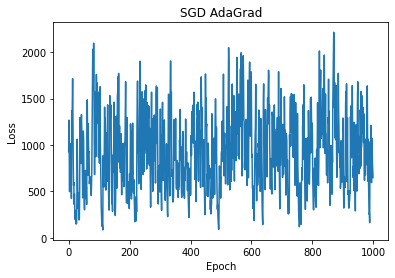

In [136]:
plt.plot(sgd_adagrad_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD AdaGrad')
plt.show()

## RMSProp

In [144]:
class RMSPropOptimizer:
  def __init__(self,lr=1e-5, eps = 1e-7, gamma=0.9):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.gamma = gamma

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)
    self.G = self.G * self.gamma + (1 - self.gamma) * (gradient ** 2)
    return weights - self.lr * gradient / np.sqrt(self.G + self.eps)

optimizer = RMSPropOptimizer()
sgd_rmsprop_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_rmsprop_losses = sgd_rmsprop_algo.train(xs, ys, 1)

Epoch: 1. Loss: 1408.1450229880247
Epoch: 2. Loss: 859.4385812661249
Epoch: 3. Loss: 1089.744531381651
Epoch: 4. Loss: 711.6424549122175
Epoch: 5. Loss: 949.4646507367997
Epoch: 6. Loss: 707.4287477586173
Epoch: 7. Loss: 1335.30682919821
Epoch: 8. Loss: 871.5243724149047
Epoch: 9. Loss: 1128.7636180109184
Epoch: 10. Loss: 724.6918224322611
Epoch: 11. Loss: 1075.6102679531846
Epoch: 12. Loss: 667.6658551104204
Epoch: 13. Loss: 602.4989705203557
Epoch: 14. Loss: 1066.36170766443
Epoch: 15. Loss: 1473.0818804941068
Epoch: 16. Loss: 1314.3466584695987
Epoch: 17. Loss: 1589.549126733049
Epoch: 18. Loss: 1024.0681668109614
Epoch: 19. Loss: 636.7399881935585
Epoch: 20. Loss: 404.34305143799605
Epoch: 21. Loss: 292.25930389494727
Epoch: 22. Loss: 743.82618242984
Epoch: 23. Loss: 1534.7648418353203
Epoch: 24. Loss: 932.9331873415005
Epoch: 25. Loss: 697.5041733734181
Epoch: 26. Loss: 548.7810754864479
Epoch: 27. Loss: 423.78849768104993
Epoch: 28. Loss: 992.4612837653015
Epoch: 29. Loss: 1456.7

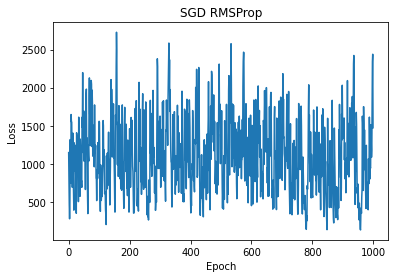

In [143]:
plt.plot(sgd_rmsprop_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD RMSProp')
plt.show()

## Adam

In [145]:
class AdamOptimizer:
  def __init__(self,lr=1e-5, eps = 1e-7, b_1=0.5, b_2=0.5):
    self.G = 0
    self.lr = lr
    self.eps = eps
    self.b_1 = b_1
    self.b_2 = b_2

  def optimize(self, weights, loss_grad, batch_xs, batch_ys):
    gradient = loss_grad(weights, batch_xs, batch_ys).mean(axis=1)

    self.m = self.G * self.b_1 + (1 - self.b_1) * gradient
    self.v = self.G * self.b_2 + (1 - self.b_2) * (gradient ** 2)

    return weights - self.lr * self.m / np.sqrt(self.v + self.eps)

optimizer = AdamOptimizer()
sgd_adam_algo = BatchGD(2, 1000, loss, loss_grad, lamb=0.4, optimizer=optimizer)

sgd_adam_losses = sgd_adam_algo.train(xs, ys, 1)

Epoch: 1. Loss: 734.4903518983674
Epoch: 2. Loss: 495.77831319520726
Epoch: 3. Loss: 637.3900191713327
Epoch: 4. Loss: 1041.7065608653934
Epoch: 5. Loss: 628.0509644829083
Epoch: 6. Loss: 1373.9433058173036
Epoch: 7. Loss: 1181.2792290060484
Epoch: 8. Loss: 1263.4448700560329
Epoch: 9. Loss: 1125.1052903460052
Epoch: 10. Loss: 1263.956136539061
Epoch: 11. Loss: 758.4468458855669
Epoch: 12. Loss: 750.9252679099025
Epoch: 13. Loss: 450.65127202848106
Epoch: 14. Loss: 325.473801244991
Epoch: 15. Loss: 1023.3643337880176
Epoch: 16. Loss: 1941.9703337861192
Epoch: 17. Loss: 2206.401824054039
Epoch: 18. Loss: 2304.6116404616405
Epoch: 19. Loss: 1390.160007169299
Epoch: 20. Loss: 1316.3873930716493
Epoch: 21. Loss: 1876.3657976916213
Epoch: 22. Loss: 1681.1435546359244
Epoch: 23. Loss: 1490.973923968858
Epoch: 24. Loss: 1006.5680951995054
Epoch: 25. Loss: 1641.3415826137536
Epoch: 26. Loss: 999.641876315672
Epoch: 27. Loss: 864.7645474582944
Epoch: 28. Loss: 1002.286906151867
Epoch: 29. Loss:

In [ ]:
plt.plot(sgd_rmsprop_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD RMSProp')
plt.show()